In [1]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt

import LE as le
import LP as lp
import iterative as iterative
import graph_viz as viz
import logger_creator

import graph_tools
import networkx as nx

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [ ]:
range_x = range(0, 5001, 200)

time_data_le = []
time_data_lp = []
time_data_iterative = []
cycles = []


logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        countdown = 5
        while countdown > 0:
            countdown -= 1

            small_world_graph = nx.watts_strogatz_graph(num_nodes, min(3, num_nodes), 0.3, seed=countdown) # min is incase num_nodes < 3
            small_world_graph = graph_tools.nx_graph_nodes_to_str(small_world_graph)
            delegation_graph = graph_tools.prepare_graph(small_world_graph.nodes(), small_world_graph.edges())
            delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
            delegations = graph_tools.invert_graph(delegations_orig)
            nodes = list(delegation_graph)

            try: 
                lp_model = lp.set_up(delegations, nodes)
                _ = lp.resolve_delegations(delegations, nodes)
                break
            except:
                print(lp_model)
                SEED += 1
                print("Graph infeasible, retrying")

        # Verify the solutions are equal
        powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes)

        if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-6 for k in powers_le):
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (powers_lp[node] - powers_iter[node] < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break


        G = graph_tools.dict_to_nx_graph(delegations_orig)
        num_cycles = len(list(nx.simple_cycles(G)))
        cycles += [num_cycles]

        n = 50
        if 0 <= num_nodes < 500:
            n = 100
        elif 500 <= num_nodes < 1000:
            n = 100
        elif num_nodes < 2000:
            n = 100

        # LE
        le_model = le.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        lp_model = lp.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
    
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes)
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)


    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

print("Average number of cycles: ", sum(cycles) / len(cycles))

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
Average number of cycles:  0.0


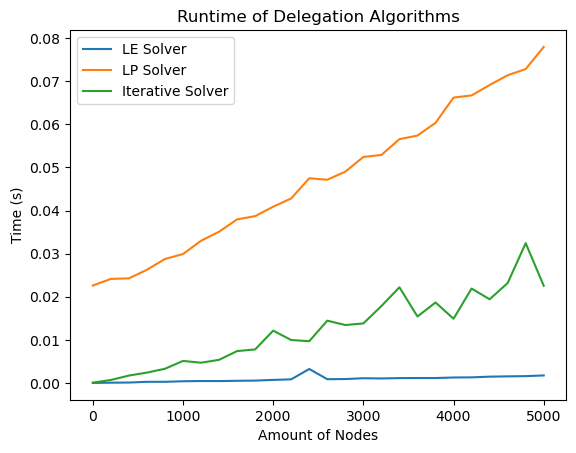

In [8]:
x = list(range_x)

plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LE Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.show()


In [7]:
print(x)
print("time_data_iterative")
print(time_data_iterative)
print("time_data_le")
print(time_data_le)
print("time_data_lp")
print(time_data_lp)

[0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000]
time_data_iterative
[[6.452083587646484e-05, 0.0006802892684936524, 0.0017075014114379882, 0.0023952889442443847, 0.003287220001220703, 0.005102930068969727, 0.004693570137023925, 0.005360591411590576, 0.007388899326324463, 0.007771050930023194, 0.012128262519836426, 0.009954099655151366, 0.009686641693115235, 0.014446558952331543, 0.013433060646057128, 0.01380444049835205, 0.017833380699157714, 0.022191643714904785, 0.015412240028381348, 0.01866219997406006, 0.01489893913269043, 0.021898055076599122, 0.019409217834472657, 0.023178281784057616, 0.03243033885955811, 0.02254281997680664]]
time_data_le
[[3.3140182495117185e-07, 5.597114562988281e-05, 8.86082649230957e-05, 0.0002565693855285645, 0.0002598905563354492, 0.00038815975189208983, 0.0004391002655029297, 0.0004277825355529785, 0.0004920196533203125, 0.0005398917198181152, 0.00070013

**Note: We can see, that none of the graphs have any cycles. This is a possible explanation why the iterative method ends up working the fastest**

# Bigger graphs

In [ ]:
range_x = range(0, 50001, 5000)

time_data_le = []
time_data_lp = []
time_data_iterative = []

logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        countdown = 5
        while countdown > 0:
            countdown -= 1

            small_world_graph = nx.watts_strogatz_graph(num_nodes, min(3, num_nodes), 0.3, seed=countdown) # min is incase num_nodes < 3
            small_world_graph = graph_tools.nx_graph_nodes_to_str(small_world_graph)
            delegation_graph = graph_tools.prepare_graph(small_world_graph.nodes(), small_world_graph.edges())
            delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
            delegations = graph_tools.invert_graph(delegations_orig)
            nodes = list(delegation_graph)

            try: 
                lp_model = lp.set_up(delegations, nodes)
                _ = lp.resolve_delegations(delegations, nodes)
                break
            except:
                print(lp_model)
                SEED += 1
                print("Graph infeasible, retrying")

        # Verify the solutions are equal
        powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes)

        if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-6 for k in powers_le):
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (powers_lp[node] - powers_iter[node] < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break

        n = 20
        if 0 <= num_nodes < 500:
            n = 100
        elif 500 <= num_nodes < 1000:
            n = 100
        elif num_nodes < 2000:
            n = 100

        # LE
        le_model = le.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        lp_model = lp.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
    
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes)
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)


    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


In [20]:
print(x)
print("time_data_iterative")
print(time_data_iterative)
print("time_data_le")
print(time_data_le)
print("time_data_lp")
print(time_data_lp)

[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000]
time_data_iterative
[[7.841110229492187e-05, 0.024668550491333006, 0.06840565204620361, 0.10012719631195069, 0.13310564756393434, 0.1816759467124939, 0.2563818097114563, 0.3149769425392151, 0.416628360748291, 0.4345307588577271, 0.4990972876548767]]
time_data_le
[[4.291534423828125e-07, 0.0016574501991271974, 0.003264892101287842, 0.004422199726104736, 0.005685853958129883, 0.007070600986480713, 0.008528995513916015, 0.010322988033294678, 0.011606597900390625, 0.012919759750366211, 0.013595247268676757]]
time_data_lp
[[0.019964978694915772, 0.07614328861236572, 0.13460885286331176, 0.18973571062088013, 0.2513334035873413, 0.33270504474639895, 0.372507643699646, 0.44359976053237915, 0.511565899848938, 0.5725200414657593, 0.6558308959007263]]


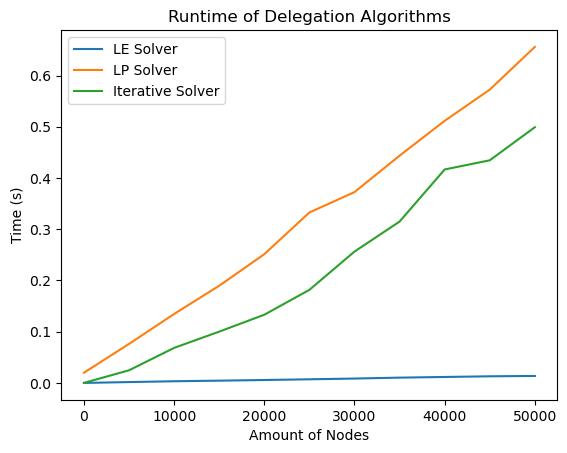

In [21]:
x = list(range_x)

plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LE Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.show()

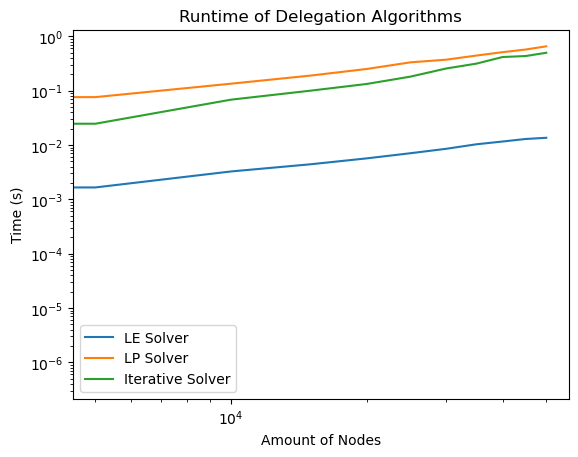

In [22]:
plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LE Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")

plt.loglog()

plt.show()

In [30]:
# Testing how the small world graphs look like
num_nodes = 15
small_world_graph = nx.watts_strogatz_graph(num_nodes, 4, 0.3, seed=1)
small_world_graph = graph_tools.nx_graph_nodes_to_str(small_world_graph)
delegation_graph = graph_tools.prepare_graph(small_world_graph.nodes(), small_world_graph.edges())
delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
delegations = graph_tools.invert_graph(delegations_orig)
nodes = list(delegation_graph)

powers, sinks = le.resolve_delegations(delegations, nodes)

viz.visualize_delegation_graph(delegations_orig, powers)

Parsing the data...Done


Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.
Address already in use
Port 8051 is in use by another program. Either identify and stop that program, or start the server with a different port.
Address already in use
Port 8052 is in use by another program. Either identify and stop that program, or start the server with a different port.


Parsing the data...Done
Parsing the data...Done
Parsing the data...Done


Graph visualization failed because no ports were found or there was another error.


No trigger
